# Customers' age determination

A chain supermarket introduces a computer vision system for processing customers' photos. Photo fixation in the checkout area will help determine the age of customers in order to:

1) Analyze purchases and offer products that may be of buyers' interest of this particular age group; <br/>
2) Control the conscientiousness of cashiers when selling alcohol.
 
The task is to build a model that determines the age of a person from a photograph. The task is a **regression task**, the metric is **MAE** (absolute error). The input data for the task is a set of photographs with the age indications.

## Contents 

<a href='#first'>1) EDA </a> <br/>
<a href='#second'>2) Machine learning </a> <br/>
<a href='#third'>3) Summary</a> <br/>

<a id='first'></a>
## 1. EDA

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


(7591, 2)

<AxesSubplot:xlabel='real_age', ylabel='Count'>

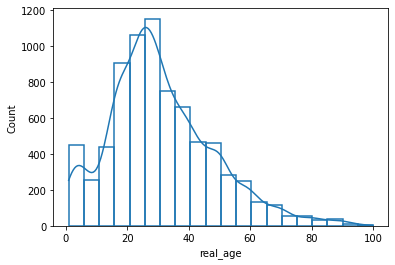

In [3]:
sns.histplot(data['real_age'], bins = 20, kde = True, fill = False)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='real_age', ylabel='Density'>

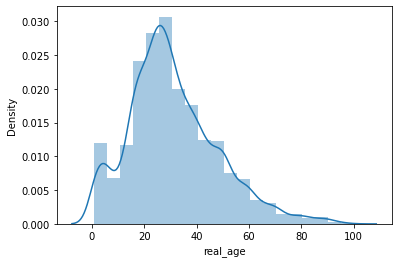

In [4]:
sns.distplot(data['real_age'], bins = 20)

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(features[2333])

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


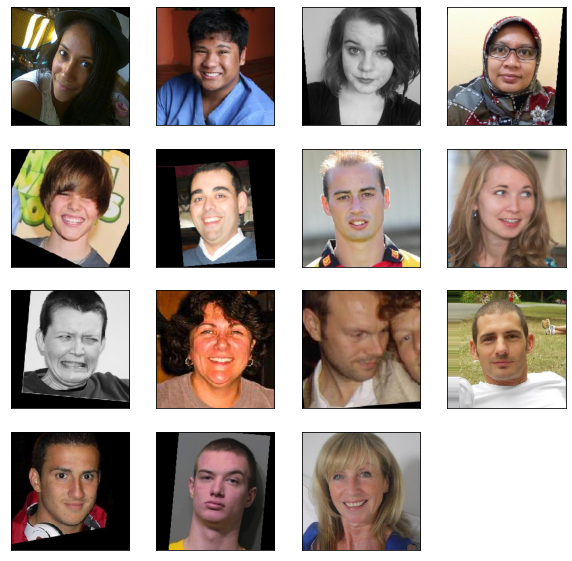

In [53]:
features, target = next(gen_flow)
fig = plt.figure(figsize = (10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])


### Conclusion

The data is a set of 7,591 photographs of people of different ages and a table indicating the age of the person in each photo. <br/>

From the age distribution graph, it can be seen that most of the photos in the dataset are people aged 25-30, or in general, the age group is from 20 to 40 years old. Another peak of the graph falls on the age group of 0-5 years, while the age over 50 years accounts for only about 10% of the dataframe. This suggests that the model might have difficulties when recognizing the age of people over 50 years old, or children from 5-10 years old. <br/>

Photos in the dataset are presented both: profile and in full face; there are photos of people with closed eyes, slightly closed faces, different emotions, while all photos show close-ups of faces. This suggests that the model will be able to better recognize faces at the checkout, as photos will be taken in motion.

To build the model, we will do augmentation with rotation_range equal to +-15-20 degrees, as there are photographs in which faces are depicted at different angles to the vertical axis.

<a id='second'></a>
## 2. Machine learning

The code in this section was run in a separate GPU trainer, so it is formatted not as a code cell, but as a markdown.

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path):
    datagen = ImageDataGenerator(rescale=1/255., validation_split= 0.25, rotation_range = 20)
    train_datagen_flow = datagen.flow_from_dataframe(
    dataframe = pd.read_csv(path+'labels.csv'),
    directory = path+'/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)
    train_data = train_datagen_flow
  
    return train_data

def load_test(path):
    datagen = ImageDataGenerator(rescale=1/255., validation_split= 0.25)
    test_datagen_flow = datagen.flow_from_dataframe(
    dataframe = pd.read_csv(path+'labels.csv'),
    directory = path+'/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
    test_data = test_datagen_flow
  
    return test_data

def create_model(input_shape):
    optimizer = Adam(lr =  0.0001)
    backbone = ResNet50(input_shape=input_shape,
                     weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                     include_top = False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size = None, epochs = 7,
               steps_per_epoch = None, validation_steps = None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=None, epochs=7,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```

Screen output:

60/60 - 9s - loss: 85.2221 - mae: 6.8123
Test MAE: 6.8123
```

<a id='third'></a>
## 3. Summary

The model was trained using the ResNet architecture with 50 layers. For the last layer, relu activation was used to replace negative predictions with 0, since the results less than 0 cannot be. The layer has with one neuron, because the task is a regression task - the model should give one answer, namely the age of the person in the photo.

The final MAE metric, or mean absolute error, on the test set is 6.8. This means that the model makes on average error of **6 years and 10 months**. This deviation may be enough to determine the age category of buyers in terms of goal number 1 - *analyze purchases and offer products that may be of interest to buyers of this age group*. From the point of view of goal number 2 - *control the conscientiousness of cashiers when selling alcohol* - the deviation is high and is unreliable to completely rely on the model - additional controls must be used.